## Week 3 - CAPSTONE: IBM Data Science Professional Certificate
# Segmenting and Clustering Neighborhoods in Toronto

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import folium
from geopy.geocoders import MapBox
from geopy.extra.rate_limiter import RateLimiter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt

In [2]:
# config file containing API KEYS
from project_config import *

In [3]:
# Geocoder setup using the MapBox API from geopy
locator = MapBox(api_key=MAPBOX_API_KEY)
# limit the rate of api calls to 1 every second to avoid being blocked
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

## SECTION 1: Zipcode Data
### Scrape the Data

Pull the data from the table on the Wikipedia Page by requesting the page and parsing the HTML.  We will use the popular requests package to make our get request and use BeautifulSoup to parse the HTML.  BeautifulSoup has an easy API to traverse the HTML nodes and search based on HTML tags and attributes.

#### Make the get request

In [4]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r = requests.get(url)
# print the sever response to make sure we get a good 200 code
print(r) 

<Response [200]>


#### Parse the page

In [5]:
# parse the page and get a list of all the tables on the page
page = BeautifulSoup(r.text, 'html.parser')


#### Find the table with the data

In [6]:
tables = page.find_all('table')
print(f'There are {len(tables)} HTML tables on the page')

There are 5 HTML tables on the page


Since there are more then one table lets pull the header cells with HTML tag of **th** to find the correct table.

In [7]:
[table.find_all('th') for table in tables]

[[<th>Postcode</th>,
  <th>Borough</th>,
  <th>Neighbourhood
  </th>],
 [],
 [],
 [<th class="navbox-title" style="font-size:110%"><a href="/wiki/Postal_codes_in_Canada" title="Postal codes in Canada">Canadian postal codes</a>
  </th>],
 []]

From the python list above we can see that the first table on the page is the one we want to scrape.

#### Parse the table

Loop over ever row in the table to get the text from each cell and map it to the column name.  Then convert to the pandas DataFrame to clean.

In [8]:
# create list of every row in the table finding the HTML tag <tr>
zipcode_table = tables[0].find_all('tr')
header = [th.get_text(strip=True) for th in zipcode_table[0].find_all('th')]

# loop over ever row and create a dict for each row
zipcodes = map(
    # function to create the dict using the header names and text value inside each cell
    lambda row: {head: cell.get_text(strip=True) for head, cell in zip(header, row.find_all('td'))},
    # skip the first row as this was the header row
    zipcode_table[1:]
)

# convert to pandas dataframe
zip_df = pd.DataFrame(zipcodes)
zip_df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Clean the Dataframe

Use the new panda.NA singleton for all missing values with the place holder "Not assigned."  Any postalcode without a Borough will be dropped, and any empty Neighbourhood will be replaced with the Borough value.

In [9]:
# convert "Not assigned" to pandas.NA types
zip_df = zip_df.replace("Not assigned", pd.NA)

In [10]:
# drop all rows without a Borough
zip_df = zip_df.dropna(subset=['Borough'])
# fill any missing Neighbourhoods with the Borough Name
zip_df['Neighbourhood'] = zip_df['Neighbourhood'].fillna(value=zip_df['Borough'])

### Transform the Dataframe

Combine all duplicated Postalcodes together by forming a comma seperated list of every Neighbourhood.  Also assuming that there is one Borough name per zipcode.

In [11]:
# For each postal code and borough group create a list of all the Neighbourhoods 
zip_df = zip_df.groupby(['Postcode','Borough']).apply(lambda x: ", ".join(x['Neighbourhood'].unique())).reset_index()
zip_df.columns = ['Postcode','Borough', 'Neighbourhood']
zip_df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Print Shape of the Dataframe

In [12]:
zip_df.shape

(103, 3)

## SECTION 2: Latitude and Longitude

Create a function to pull the latitude and longitude from the "zipcode, city, country" from geocoder form MapBox using the geopy package

In [13]:
def zip_to_coords(zipcode: str, city: str, state: str, country: str):
    """ Get the latitude and longitude from the the given zipcode using the geocode form geopy """
    address = f'{city}, {state}, {zipcode}, {country}'
    location = geocode(address)
    return pd.Series((location.latitude, location.longitude))

Create a new column in the zipcode dataframe for the latitude and longitude

***Note:*** *Only run this cell below if you haven't already saved the CSV as this will take a few minutes to search for all the coordinates and will consume your MapBox resources*

In [14]:
zip_df[['Latitude', 'Longitude']] = zip_df['Postcode'].apply(zip_to_coords, args=('Toronto', 'Ontario', 'Canada'))
zip_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.808241,-79.220533
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.780000,-79.190000
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.770000,-79.190000
3,M1G,Scarborough,Woburn,43.780000,-79.230000
4,M1H,Scarborough,Cedarbrae,43.780000,-79.250000


In [15]:
# export dataframe as a csv
zip_df.to_csv('week3_data.csv')

## SECTION 3: Cluster and Map

In [16]:
# download the csv if created, so we can skip the code above
zip_df = pd.read_csv('week3_data.csv', index_col=0)
zip_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.808241,-79.220533
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.780000,-79.190000
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.770000,-79.190000
3,M1G,Scarborough,Woburn,43.780000,-79.230000
4,M1H,Scarborough,Cedarbrae,43.780000,-79.250000


Get the coordinates of Toronto, Ontario, Canada to create the folium map centered on the city.

In [17]:
tor_loc = geocode('Toronto, Ontario, Canada')
print(f"{tor_loc} is located at {tor_loc.latitude}, {tor_loc.longitude}")

Toronto, Ontario, Canada is located at 43.6529, -79.3849


### Map of Toronto

I am choosing to exclude Downtown Toronto as the Postal Codes in that area are very dense, so this allows me to use Postal Codes that are much more evenly spaced out.  See below for Downtown Toronto in Blue.

In [18]:
tor_map = folium.Map(location=[tor_loc.latitude, tor_loc.longitude], zoom_start=10)

exclude_downtown = zip_df['Borough']!='Downtown Toronto'

# Postal markers for everything but Downtown Toronto
for mark in zip_df.loc[exclude_downtown,:].itertuples():
    label = f"{mark.Borough}, {mark.Postcode} ({mark.Neighbourhood})"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [mark.Latitude, mark.Longitude],
        radius=5,
        popup=label,
        color='#E97900',
        fill=True,
        fill_color='#F7BB2D',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(tor_map)

# Postal markers for Downtown Toronto
for mark in zip_df.loc[-exclude_downtown,:].itertuples():
    label = f"{mark.Borough}, {mark.Postcode} ({mark.Neighbourhood})"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [mark.Latitude, mark.Longitude],
        radius=5,
        popup=label,
        color='#0071e9',
        fill=True,
        fill_color='#56b3ff',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(tor_map)
tor_map

In [19]:
# New Dataframe without Downtown Toronto
tor_df = zip_df.loc[exclude_downtown,:]
tor_df.shape

(84, 5)

### Foursquare API

Create a function to access the Foursquare "venues/explore" endpoint and parse the JSON into records to put into a dataframe.

In [20]:
def parse_results(results: dict, postcode: str):
    """ Parses the JSON results returned from the https://api.foursquare.com/v2/venues/explore endpoint """
    # Collect all the venue objects nested under the items list
    venues = [item['venue'] for item in results['response']['groups'][0]['items']]
    
    # Create the list of all the places
    places = list()
    
    # loop over each venue to create the record for each place
    for venue in venues:
        places.append({
            'venue_id': venue['id'],
            'Name': venue['name'],
            'Category': venue['categories'][0]['name'],      
            'Latitude': venue['location']['lat'],
            'Longitude': venue['location']['lng'],
            'Distance': venue['location']['distance'],
            'Postcode': postcode
        })

    return places

def explore_venues(postcode: str, lat: float, lon: float, section: str = None, radius: int = 1000, limit: int = 100):
    """ Access the Foursquare API venues/explore enpoint
    Params:
        postcode (str): Postal code to label each place
        lat (float): latitude of search
        lon (float): longitude of search
        section (str): category to search, choose from:
            [food, drinks, coffee, shops, arts, outdoors, sights, trending, nextVenues, topPicks]
        radius (int): radius from the coordinates to search
        limit (int): limit the number of results returned
    """
    
    # Paramater defintion for the endpoint
    params = {
        'client_id': FOURSQUARE_CLIENT_ID,
        'client_secret': FOURSQUARE_CLIENT_SECRET,
        'v': '20200305',
        'll': f"{lat},{lon}",
        'radius': radius,
        'limit': limit         
    }
    
    # if there is a valid section provided add it to the parameters
    if section in ['food', 'drinks', 'coffee', 'shops', 'arts', 'outdoors', 'sights', 'trending', 'nextVenues', 'topPicks']:
        params['section'] = section
        
    
    # endpoint to access
    endpoint = 'https://api.foursquare.com/v2/venues/explore'
    
    # GET request
    r = requests.get(endpoint, params=params)
    
    # check to make sure we get a good 200 status code
    if r.status_code != 200:
        print(r.status_code)
        print(r.text)
        return None
      
    return parse_results(r.json(), postcode)     

For my analysis I am going to search for all places with section="food" within a 1.5km radius of each Postalcode center.  I will loop over every Postal Code in and make a call to the Foursquare API, and then I will convert the records into a DataFrame for anaylsis.

In [21]:
food = list()
# Loop over the coordiantes of every postal code and return the top 100 food venues within a 1.5km radius
for postcode in tor_df.itertuples():
    food.extend(explore_venues(postcode.Postcode, postcode.Latitude, postcode.Longitude, section='food', radius=1500))
len(food)

3909

In [22]:
# convert the records from the Foursquare API into a Dataframe and save the csv
food_df = pd.DataFrame(food)
food_df.to_csv('toronto_food.csv')
food_df.shape

(3909, 7)

In [23]:
# load the saved dataset so we don't have to make another api call to foursquare
food_df = pd.read_csv('toronto_food.csv', index_col=0)

In [24]:
# Merge the Borough and Neighborhood data into the food data 
tor_food = food_df.merge(tor_df[['Postcode', 'Borough', 'Neighbourhood']], how='left', on="Postcode")
tor_food.head()

,venue_id,Name,Category,Latitude,Longitude,Distance,Postcode,Borough,Neighbourhood
0,4c68119de1da1b8d45179fc3,Subway,Sandwich Place,43.806961,-79.221476,161,M1B,Scarborough,"Rouge, Malvern"
1,4bf0817e24f020a11c33684f,Pizza Pizza,Pizza Place,43.806613,-79.221243,189,M1B,Scarborough,"Rouge, Malvern"
2,4cb9e2d84495721e640c4d7a,Pizza Hut,Pizza Place,43.808326,-79.220616,11,M1B,Scarborough,"Rouge, Malvern"
3,4d18ffb61356a093b0d1e682,KFC,Fast Food Restaurant,43.806812,-79.220786,160,M1B,Scarborough,"Rouge, Malvern"
4,4e00fd4c7d8beaa1649e49f8,Taco Bell,Restaurant,43.806853,-79.220859,156,M1B,Scarborough,"Rouge, Malvern"


In [25]:
print(f"There are {tor_food['Category'].unique().shape[0]} food categories within the dataset")

There are 117 food categories within the dataset


Convert dtypes within the dataset to reduce the size

In [26]:
# convert data types to categorical dtypes
cat_list = ['Category', 'Postcode', 'Borough', 'Neighbourhood'] 
for cat in cat_list:
    tor_food[cat] = tor_food[cat].astype('category')
# convert to string type
text_list = ['venue_id', 'Name']
for text in text_list:
    tor_food[text] = tor_food[text].astype('string')
tor_food.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3909 entries, 0 to 3908
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   venue_id       3909 non-null   string  
 1   Name           3909 non-null   string  
 2   Category       3909 non-null   category
 3   Latitude       3909 non-null   float64 
 4   Longitude      3909 non-null   float64 
 5   Distance       3909 non-null   int64   
 6   Postcode       3909 non-null   category
 7   Borough        3909 non-null   category
 8   Neighbourhood  3909 non-null   category
dtypes: category(4), float64(2), int64(1), string(2)
memory usage: 211.1 KB


### K-Means Clustering

Create the feature set to run the K-Means Clusterin algorithm.

In [27]:
cluster_features = tor_food[['Postcode', 'Distance']].join(pd.get_dummies(tor_food['Category']))
cluster_features = cluster_features.groupby('Postcode').mean()
# scale the average distance so it is between 0 and 1
min_dist = cluster_features['Distance'].min()
max_dist = cluster_features['Distance'].max()
cluster_features['Distance'] = 0.5 * (cluster_features['Distance'] - min_dist) / (max_dist - min_dist)
cluster_features.shape

(84, 118)

Lets figure out the best k to use by ploting the sum of squared distances from the points centroids and see where there is an elbow in the plot.

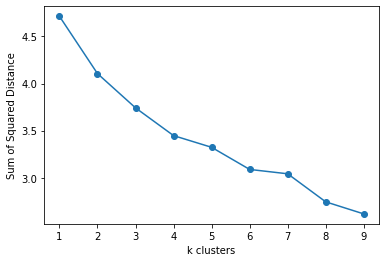

In [28]:
# store the sse for each run from k=1 - k=8
ssd = list()
k_to_try = list(range(1,10))
for k in k_to_try:
    km = KMeans(n_clusters=k, random_state=3)
    km.fit(cluster_features)
    ssd.append(km.inertia_)

fig, ax = plt.subplots()
ax.plot(k_to_try, ssd, '-o')
ax.set_xlabel("k clusters")
ax.set_ylabel("Sum of Squared Distance")
plt.show()

Since the above graph doesn't make it very clear, we will compare k=2 or 3 using Silhouette Analysis.  The function below is taken from a medium article outlined by Imad Dabbura in [K-means Clustering: Algorithm, Applications, Evaluation Methods, and Drawbacks](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a).

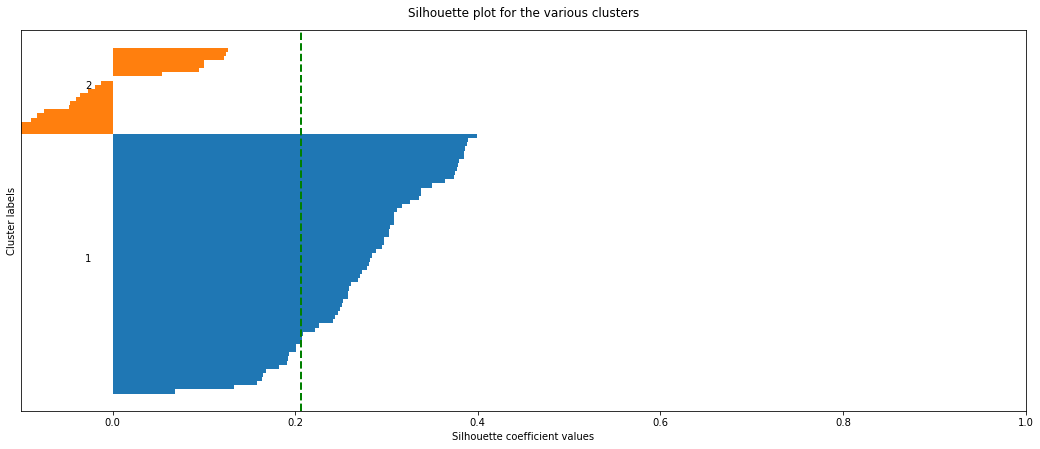

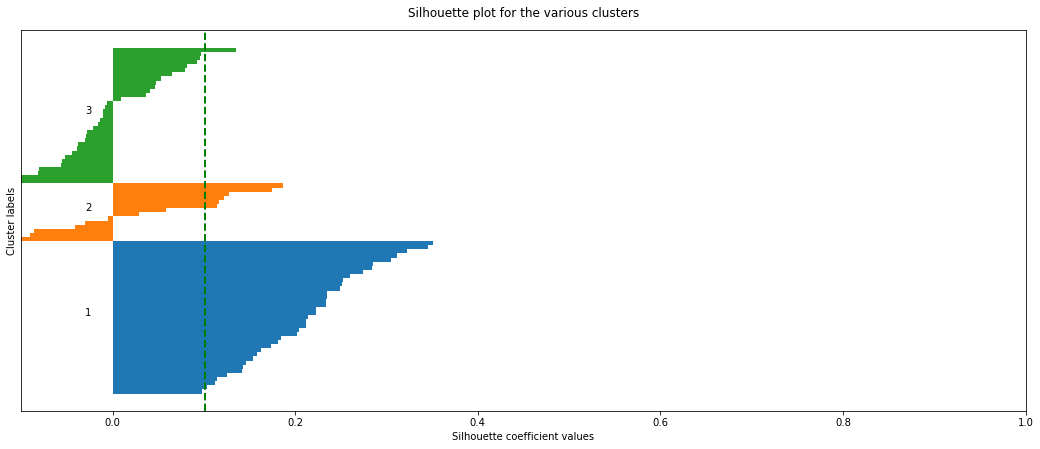

In [29]:
for i, k in enumerate([2, 3]):
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(cluster_features)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(cluster_features, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])
    ax.set_xlabel('Silhouette coefficient values')
    ax.set_ylabel('Cluster labels')
    ax.set_title('Silhouette plot for the various clusters', y=1.02);

From the graph above, 2 has the heigher average Silhouette Coefficient signified by the green dotted line.  We will use k=2.

In [30]:
# Final Cluster
k=2
km = KMeans(n_clusters=k, random_state=3)
km.fit(cluster_features)
clusters = cluster_features.reset_index()[['Postcode']].join(pd.Series(km.labels_, name="Cluster"))
clusters.head()

,Postcode,Cluster
0,M1B,0
1,M1C,0
2,M1E,0
3,M1G,1
4,M1H,1


### Examine Clusters

Create a map of the clusters

In [31]:
# Create a map showing where each cluster is at
tor_map = folium.Map(location=[tor_loc.latitude, tor_loc.longitude], zoom_start=10)

palette = [('#007153','#54bda1'),('#71001e','#ce3f39') ]

# Postal markers for everything but Downtown Toronto
for mark in clusters.merge(tor_df, how='left', on="Postcode").itertuples():
    label = f"{mark.Borough}, {mark.Postcode} ({mark.Neighbourhood})"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [mark.Latitude, mark.Longitude],
        radius=5,
        popup=label,
        color=palette[mark.Cluster][0],
        fill=True,
        fill_color=palette[mark.Cluster][1],
        fill_opacity=0.7,
        parse_html=False
    ).add_to(tor_map)

tor_map

In [32]:
# average number of food venues in a 1.5km radius
num_food = clusters.merge(tor_food.groupby('Postcode')['venue_id'].count().rename("Food").reset_index(), how="left", on="Postcode")
num_food.groupby('Cluster').describe()

Food                                                     
        count       mean        std  min    25%   50%   75%    max
Cluster                                                           
0        16.0  16.375000  10.019148  4.0  10.25  16.0  20.5   43.0
1        68.0  53.632353  29.703462  4.0  27.50  46.5  83.0  100.0

From this we can see the areas in cluster 0 has fewer food venues within a 1.5 km radius than in cluster 1.

In [33]:
# average distance
dist_food = clusters.merge(tor_food.groupby('Postcode')['Distance'].mean().rename("dist").reset_index(), how="left", on="Postcode")
dist_food.groupby('Cluster').describe()

dist                                                              \
        count        mean         std         min         25%         50%   
Cluster                                                                     
0        16.0  914.072721  257.790583  448.318182  715.671875  922.519886   
1        68.0  859.525668  184.464340   88.750000  761.910839  880.037143   

                              
                 75%     max  
Cluster                       
0        1052.054167  1436.6  
1         979.801905  1196.0

We can also see that cluster 0 has food venues slightly further away from the postal code center then cluster 1.

NameError: name 'width' is not defined

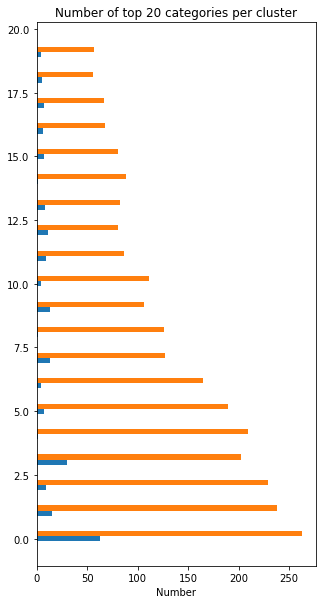

In [34]:
# Types of food
# Number of each type of food venue per postcode
num_food = tor_food[['Postcode']].join(pd.get_dummies(tor_food['Category']))
num_food = num_food.groupby('Postcode').sum()
# Get top 20 overall food types
top_20 = list(num_food.sum().sort_values(ascending=False)[0:20].index)
top_20_food = clusters.merge(num_food[top_20].reset_index(), how="left", on="Postcode")
top_20_food = top_20_food.groupby('Cluster').sum()

fig, ax = plt.subplots(figsize=(5,10))
idx = np.arange(20) 
bar_width = 0.2

plt.barh(idx, top_20_food.loc[0,:].values, bar_width, label="cluster 0")
plt.barh(idx + bar_width, top_20_food.loc[1,:].values, bar_width, label="cluster 1")
plt.xlabel('Number')
plt.title('Number of top 20 categories per cluster')

plt.yticks(idx + width / 2, top_20)
plt.legend(loc='best')
plt.show()



From this it is hard to tell whether the clusters have much to do with the types of food venues in each cluster and I think the quantity of resturants is overpowering the types in the clustering algorithm.